In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy.random as rnd

In [7]:
import data_gen as gen
import importlib
importlib.reload(gen)

print(gen.Gaussian_mixture().out)

1


## Logistic Regression, Softmax and Gradient Descent

### Generate some 2D data to work with

In [202]:
x_dim = 2
n_class = 2
n_samples = 100
xs_mu = [rnd.uniform(-5, 5, (x_dim)) for _ in range(n_class)]
xs_sigma = [rnd.uniform(2, 4, (x_dim)) for _ in range(n_class)]

Xs = []
for _mu, _sigma in zip(xs_mu, xs_sigma):
    Xs.append(rnd.normal(_mu, _sigma, (n_samples, x_dim)))

### Visualize generated data

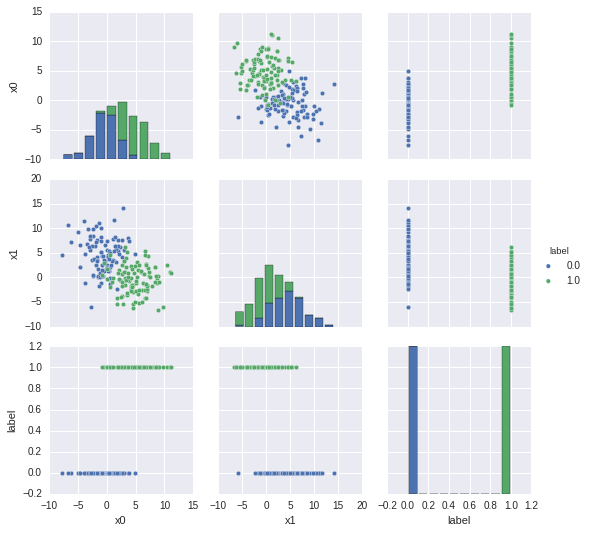

In [203]:
import pandas as pd


X_dfs = []
for i, _X in enumerate(Xs):
    _label = i*np.ones((_X.shape[0], 1))
    _df = pd.DataFrame(_X)
    _df['label'] = _label
    X_dfs.append(_df)
    
X_df = pd.concat(X_dfs)
col_names = ["x"+str(i) for i in range(x_dim)]
col_names.append('label')
X_df.columns = col_names
sns.pairplot(X_df, hue='label')
plt.show()

In [204]:
def mix_shuffle(_Xs):
    _Xs_lb = []
    for i, _X in enumerate(_Xs):
        _label = i*np.ones((_X.shape[0], 1))
        _X = np.hstack((_X, _label))
        _Xs_lb.append(_X)
        
    _mixed = np.vstack(_Xs_lb)
    rnd.shuffle(_mixed)
    _ft_all = _mixed[:, :2]
    _lb_all = np.round(_mixed[:, 2]).astype(int)
    return _ft_all, _lb_all

fts, lbs = mix_shuffle(Xs)

def split(_fts, _lbs, test_ratio):
    indices = range(_lbs.size)
    i_test = rnd.choice(indices, size=round(test_ratio*_lbs.size))
    i_train = np.array([i for i in indices if i not in i_test])
    return (_fts[i_train,:], _lbs[i_train]), (_fts[i_test,:], _lbs[i_test])

(tr_fts, tr_lbs), (tst_fts, tst_lbs) = split(fts, lbs, 0.2)

### Frequentist Logistic regression:

#### The model:
$$Y|X \sim \text{Bernolli}( \frac{1}{1+e^{-wX}})$$

#### MLE:
* log-likelihood: 

$
\begin{align*}
    &\log{P(Y_1, Y_2, \ldots, Y_n\mid X_1, X_2, \ldots, X_n, w)}    \\
    =& \log{\prod_{i=1}^{n} {P(Y_i \mid X_i, w)}} \\
    =& \sum_{i=1}^{n}{\log{P(Y_i \mid X_i, w)}} \\
    & \text{(Assume $Y_i$ is bernolli distrubuted with $p=\frac{1}{1+e^{-wX}}$)} \\
    =& \sum_{i=1}^{n}{\log{P(Y_i=1 \mid X_i, w)^{I_{Y_i=1}}P(Y_i=0 \mid X_i, w)^{I_{Y_i=0}}}} \\
    =& \sum_{i=1}^{n}{\log{p^{I_{Y_i=1}}(1-p)^{I_{Y_i=0}}}} \\
    =& \sum_{i=1}^{n}{{I_{Y_i=1}}\log{p} +{I_{Y_i=0}}\log{(1-p)}} \\
    =& \sum_{i=1}^{n}{Y_i\log{p} + (1-Y_i)\log{(1-p)}} \\
    =& \sum_{i=1}^{n}{Y_i\log{\frac{p}{1-p}} + \log{(1-p)}} \\
    =& \sum_{i=1}^{n}{Y_iwX_i + \log{\frac{e^{-wX_i}}{1+e^{-wX_i}}}} \\
    =& \sum_{i=1}^{n}{Y_iwX_i - wX_i - \log{(1+e^{-wX_i})}} \\
\end{align*}
$

* Maximize log-likelihood by gradient descent(ascent): 
Gradient: 

$
\begin{align*}
    & \nabla_w{(\sum_{i=1}^{n}{Y_iwX_i - wX_i - \log{(1+e^{-wX_i})}})} \\
    =& \sum_{i=1}^{n} Y_iX_i - X_i + \frac{X_i}{1+e^{wX_i}}\\
    =& \sum_{i=1}^{n} Y_iX_i - X_i\frac{1}{1+e^{-wX_i}}\\
    & \text{(Let}\hat{Y}_i = \frac{1}{1+e^{-wX_i}}) \\
    =& \sum_{i=1}^{n} (Y_i-\hat{Y}_i) X_i\\
\end{align*}
$

Find the maximum by: 

$
    w_{i+1} = w_{i} + \sum_{i=1}^{n} (Y_i-\hat{Y}_i) X_i
$

In [249]:
def logistic(_x, _w):  
    # _x : numpy 2DArray
    # _w : numpy 1DArray
    # _w.size = _x.shape[1]
    return 1/(1 + np.exp(-_x.dot(_w)))

max_iter = 100
min_err_change = 0.0001

lr = 1  # Learning rate
beta = 0.8 # Backtracking
alpha = 0.5 # Backtracking
w0 = None

w = rnd.uniform(-1, 1, x_dim)

def log_likelihood(_X, _Y, _w):
    wX = _X.dot(w)
    return (_Y - 1).dot(wX) - np.sum(np.logaddexp(0, -wX))
    
err0 = None
for _ in range(max_iter):
    pred_lbs = logistic(tr_fts, w)
    diff_lb = tr_lbs - pred_lbs
    err = np.sum(np.abs(diff_lb))
    
    _lll = log_likelihood(tr_fts, tr_lbs, w)
    print((err, _lll, w))
    if err0:
        if abs(err - err0) < min_err_change:
            print(_)
            break
    err0 = err
    grad = diff_lb.dot(tr_fts)
    while log_likelihood(tr_fts, tr_lbs, w+lr*grad) > _lll + lr*alpha*grad.dot(grad):
        lr *= beta
    w += lr*grad

def regress(_x):
    return logistic(_x, w)

(24.961301091310546, -40.541562414588896, array([ 0.52017597, -0.73716906]))
(72.147946915238066, -10310.216957291437, array([ 43.5274296 ,  28.21476431]))
(32.0, -21351.030773626058, array([  59.82558895, -362.31928225]))
(18.999999999990131, -8512.1099302095972, array([ 168.40689842, -285.46173443]))
(13.0, -5540.8745342346665, array([ 209.68844405, -231.2891252 ]))
(12.999997776024713, -4532.5323851107823, array([ 219.9077584 , -198.06773334]))
5


In [207]:
import bokeh as bk
bk.io.output_notebook()

Loading BokehJS ...

In [250]:
import bokeh.charts as bc
import bokeh.plotting as bp
from bokeh.palettes import Spectral11, Blues9

p = bp.figure(plot_width=600, plot_height=600, x_range=[-8, 8], y_range=[-8, 8])

# p = bc.Scatter(
#     X_hat_df, x='x0', y='x1', color='label'
#     )
plt_res = 100
plt_mesh = np.linspace(-8,8,plt_res)
_xx, _yy = np.meshgrid(plt_mesh, plt_mesh)
y_hats = regress(np.vstack((np.ravel(_xx), np.ravel(_yy))).T)
y_hats_xy = y_hats.reshape((plt_res, plt_res))

p.image(image=[y_hats_xy], x=[-8], y=[-8], dw=[16], dh=[-16], palette=Blues9[-5:])
for i, _x in enumerate(tr_fts):
    _l = tr_lbs[i]
    _c = Spectral11[_l%11]
    p.circle(x=_x[0], y=_x[1], color=_c)
bc.show(p)

### Multi-class Logistic Regression

* Assumption:

$$
Y|X = \text{Categorical}(p_1, \ldots, p_n = \frac{e^{w_n X}}{\sum_{k=1}^{n}{e^{w_k X}} })
$$

* Log likelihood:

$
\begin{align*}
    &\log{P(Y_1, Y_2, \ldots, Y_n\mid X_1, X_2, \ldots, X_n, w_1, \ldots, w_n)}    \\
    =& \log{\prod_{i=1}^{n} {P(Y_i \mid X_i, w_1, \ldots, w_n)}} \\
    =& \sum_{i=1}^{n}{\log{P(Y_i \mid X_i, w_1, \ldots, w_n)}} \\
    & (\text{Assume $Y_i$ is catigorical distrubuted with} p_1, \ldots, p_n) \\
    =& \sum_{i=1}^{n}{\log{\prod_{k=1}^{n}{P(Y_i=1 \mid X_i, w_k)^{I_{Y_i=k}}}}} \\
    =& \sum_{i=1}^{n}{\sum_{k=1}^n {\log{p_k^{I_{Y_i=k}}}}} \\
    =& \sum_{i=1}^{n}{\sum_{k=1}^n {I_{Y_i=k}\log{p_k}}} \\
    =& \sum_{i=1}^{n}{\sum_{k=1}^n {Y_i\log{\frac{e^{w_n X_i}}{\sum_{k=1}^{n}{e^{w_k X_i}}}}}} \\
    =& \sum_{i=1}^{n}{\sum_{k=1}^n {Y_i(w_k X_i - \log{\sum_{k=1}^{n}{e^{w_k X_i}}})}} \\
\end{align*}
$

* Gradient of log likelihood

$
\begin{align*}
    &\nabla_W{\sum_{i=1}^{n}{\sum_{k=1}^n {Y_i(w_k X_i - \log{\sum_{k=1}^{n}{e^{w_k X_i}}})}}}\\
    =& \sum_{i=1}^{n}{Y_i X_i + \hat{Y}_i X_i} \\
    &(\text{where } \hat{Y}_i = \frac{e^{w_n X_i}}{\sum_{k=1}^{n}{e^{w_k X_i}}})
\end{align*}
$


In [ ]:
def softmax(_x, _W):  
    # _x : numpy 2DArray
    # _w : numpy 1DArray
    # _w.size = _x.shape[1]
    
    return 1/np.sum(np.exp(_x.dot(_W)))

max_iter = 100
min_err_change = 0.0001

lr = 1  # Learning rate
beta = 0.8 # Backtracking
alpha = 0.5 # Backtracking
w0 = None

w = rnd.uniform(-1, 1, x_dim)

def log_likelihood(_X, _Y, _w):
    wX = _X.dot(w)
    return (_Y - 1).dot(wX) - np.sum(np.logaddexp(0, -wX))
    
err0 = None
for _ in range(max_iter):
    pred_lbs = logistic(tr_fts, w)
    diff_lb = tr_lbs - pred_lbs
    err = np.sum(np.abs(diff_lb))
    
    _lll = log_likelihood(tr_fts, tr_lbs, w)
    print((err, _lll, w))
    if err0:
        if abs(err - err0) < min_err_change:
            print(_)
            break
    err0 = err
    grad = diff_lb.dot(tr_fts)
    while log_likelihood(tr_fts, tr_lbs, w+lr*grad) > _lll + lr*alpha*grad.dot(grad):
        lr *= beta
    w += lr*grad

def regress(_x):
    return logistic(_x, w)